#  **Movie Recommender system**

## Maryam Ghafourian          

## Hamidreza Aminorroayaei 

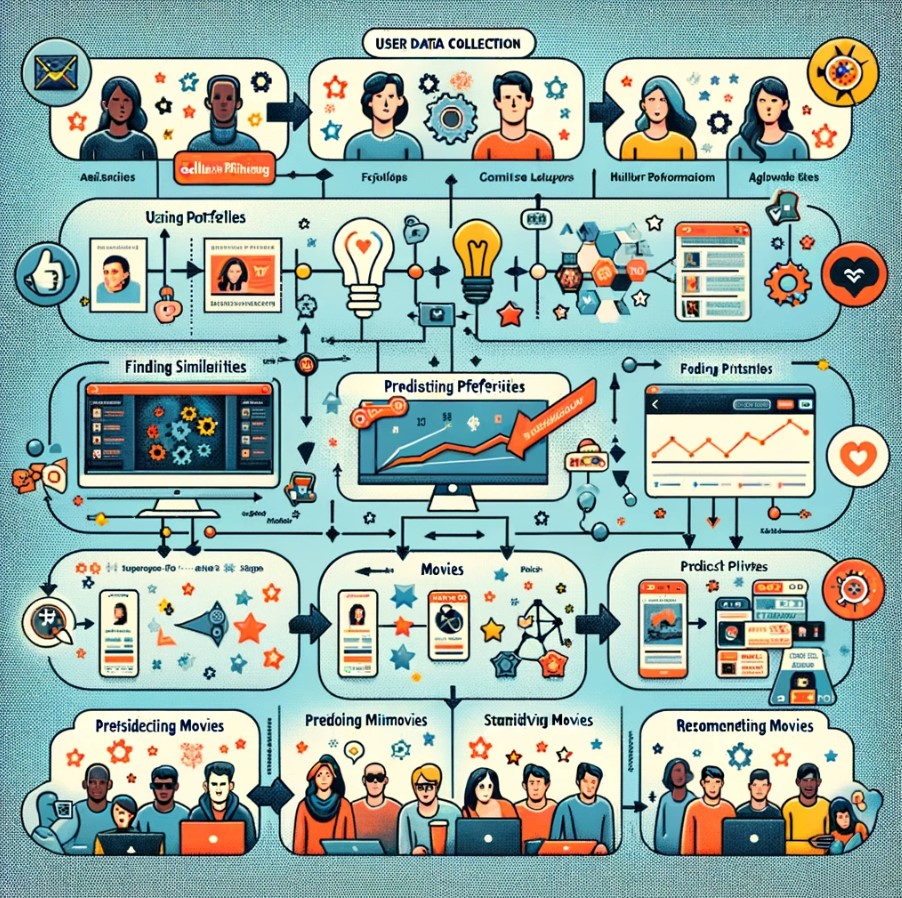

* # Step 1: Import necessary libraries

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors



* # Step 2: Load books data

In [4]:

books = pd.read_csv(r'C:\Users\Hamidreza\OneDrive\Desktop\web project\Book-DataSet/books.csv', 
                    sep=";", on_bad_lines='skip', encoding='latin-1', low_memory=False)

books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

books.rename(columns={"Book-Title": "title", "Book-Author": "author", "Year-Of-Publication": "year", "Publisher": "publisher"}, inplace=True)


In [5]:
books.head()

,ISBN,title,author,year,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [5]:
books.shape

(271360, 5)

* # Step 3: Load users data

In [6]:

users = pd.read_csv(r'C:\Users\Hamidreza\OneDrive\Desktop\web project\Book-DataSet/users.csv', 
                    sep=";", on_bad_lines='skip', encoding='latin-1', low_memory=False)


* # Step 4: Load ratings data

In [7]:

ratings = pd.read_csv(r'C:\Users\Hamidreza\OneDrive\Desktop\web project\Book-DataSet/ratings.csv', 
                      sep=";", on_bad_lines='skip', encoding='latin-1', low_memory=False)
ratings.rename(columns={"User-ID": "user_id", "Book-Rating": "rating"}, inplace=True)


In [8]:
ratings.head()

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


* # Step 5: Data exploration and visualization

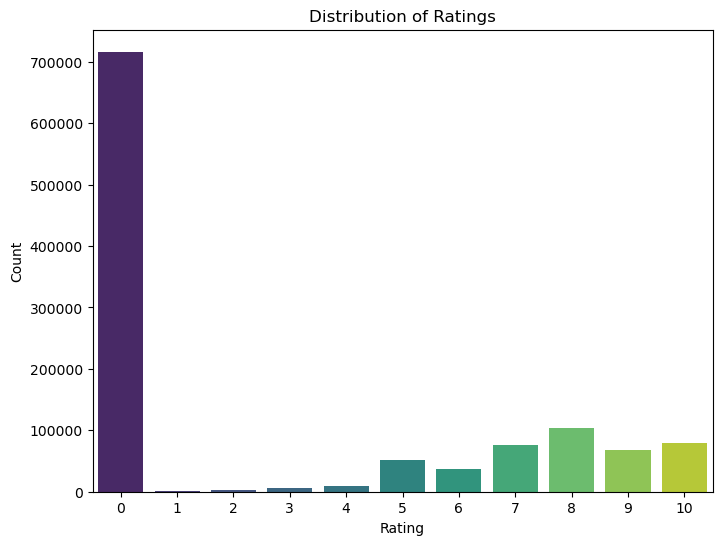

In [9]:
# Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


* # Step 6: Filtering users who rated more than 200 books

### To ensure statistical significance, users with less than 200 ratings are excluded.


In [10]:

user_counts = ratings['user_id'].value_counts()
active_users = user_counts[user_counts > 200].index
ratings = ratings[ratings['user_id'].isin(active_users)]

In [11]:
ratings.head()

,user_id,ISBN,rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


####  Visualization of user activity after filtering

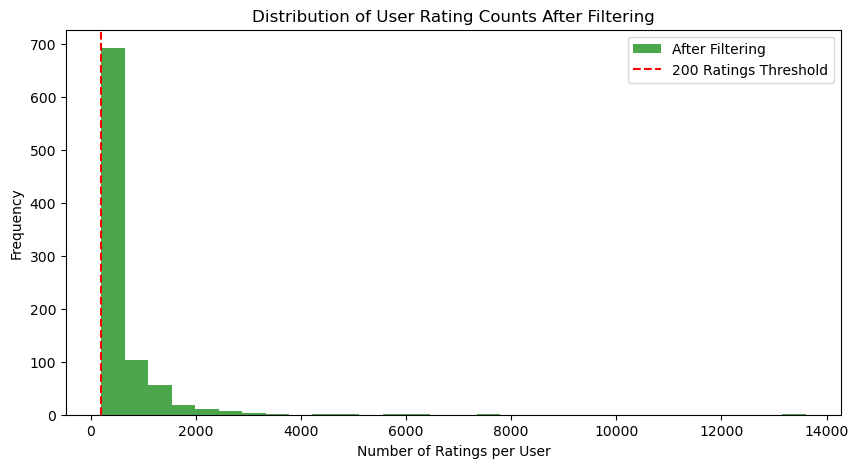

In [22]:
import matplotlib.pyplot as plt

# Assuming 'ratings' is your initial DataFrame and 'active_users' is defined as per your description


plt.figure(figsize=(10, 5))
user_counts_after = ratings[ratings['user_id'].isin(active_users)]['user_id'].value_counts()
plt.hist(user_counts_after, bins=30, alpha=0.7, color='green', label='After Filtering')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.title('Distribution of User Rating Counts After Filtering')
plt.axvline(x=200, color='r', linestyle='--', label='200 Ratings Threshold')
plt.legend()
plt.show()

* # Step 7: Preparing data for modeling

### to only include books that have received 50 or more ratings.
It ensures that the dataset focuses on books with a significant number of ratings, which might be more relevant for building a reliable recommender system.

In [12]:

ratings_with_books = ratings.merge(books, on="ISBN")
num_ratings = ratings_with_books.groupby('title')['rating'].count().reset_index()
num_ratings.rename(columns={"rating": "number_of_rating"}, inplace=True)       #This line renames the 'rating' column in the num_ratings DataFrame to 'number_of_rating' for clarity. This column now represents the total number of ratings each book has received.
final_ratings = ratings_with_books.merge(num_ratings, on='title')
final_ratings = final_ratings[final_ratings['number_of_rating'] >= 50]         # to include only those books that have received 50 or more ratings. It's a common practice in recommender systems to filter out items with too few ratings to ensure that recommendations are based on items with sufficiently reliable rating data.
final_ratings.drop_duplicates(['user_id', 'title'], inplace=True)              #This line renames the 'rating' column in the num_ratings DataFrame to 'number_of_rating' for clarity. This column now represents the total number of ratings each book has received.
book_pivot = final_ratings.pivot_table(columns='user_id', index='title', values='rating')


In [13]:
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


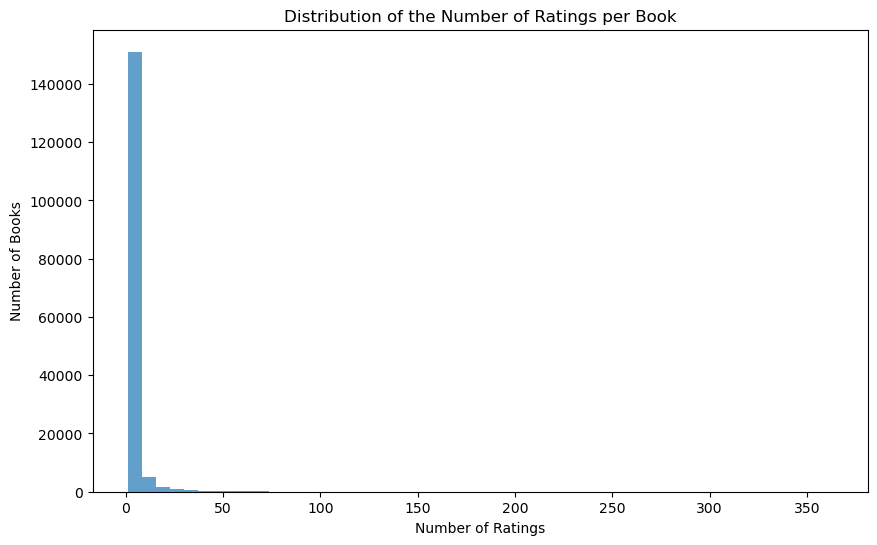

In [33]:
import matplotlib.pyplot as plt

# Assuming num_ratings is already defined as in your code
plt.figure(figsize=(10, 6))
plt.hist(num_ratings['number_of_rating'], bins=50, alpha=0.7)
plt.title('Distribution of the Number of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
plt.show()

### convert missing values
We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

In [14]:
book_pivot.fillna(0,inplace=True)                                      # Give 0 value to non-value solts 
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* # Step 8: Model Training

#### This block converts the book_pivot DataFrame into a Compressed Sparse Row (CSR) matrix named book_sparse. A CSR matrix is a storage-efficient way to represent a sparse matrix where most of the elements are zeros. Sparse matrices are common in recommender systems, especially when using collaborative filtering, because not every user rates every item, leading to a lot of missing (implicitly zero) values. Converting to a CSR format helps manage memory usage and improve computation efficiency when dealing with large datasets. 

In [15]:

book_sparse = csr_matrix(book_pivot)
model = NearestNeighbors(algorithm='brute') # Here, an instance of the NearestNeighbors class from sklearn.neighbors is created, with the algorithm set to 'brute'. The NearestNeighbors class is used to find the k-nearest neighbors of a point. Setting the algorithm parameter to 'brute' forces the algorithm to use a brute-force search. This means it will compute the distance between each pair of points in the dataset to find the nearest neighbors. While this method is computationally expensive, it's straightforward and can be precise, especially for smaller datasets or when the dimensionality of the data isn't too high.
model.fit(book_sparse)


NearestNeighbors(algorithm='brute')

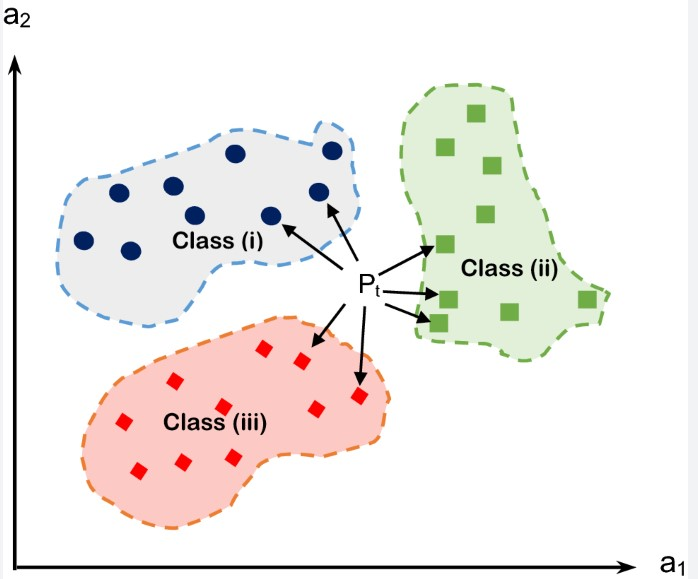

* # Step 9: Recommendation Function

In [16]:

def recommend_book(book_name):
    book_id = np.where(book_pivot.index == book_name)[0]
    if len(book_id) == 0:
        print("Book not found.")
        return
    distance, suggestion = model.kneighbors(book_pivot.iloc[book_id, :].values.reshape(1, -1), n_neighbors=6)
    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        print(f"Recommendations based on {book_name}:")
        for book in books:
            print(book)


* # Step 10: Test the Recommendation Function

In [48]:

book_name = 'Zoya'
recommend_book(book_name)


Recommendations based on Zoya:
Zoya
Fine Things
Exclusive
Secrets
The Cradle Will Fall
Kaleidoscope


# Clustering Visualization

C:\Users\Hamidreza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Hamidreza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


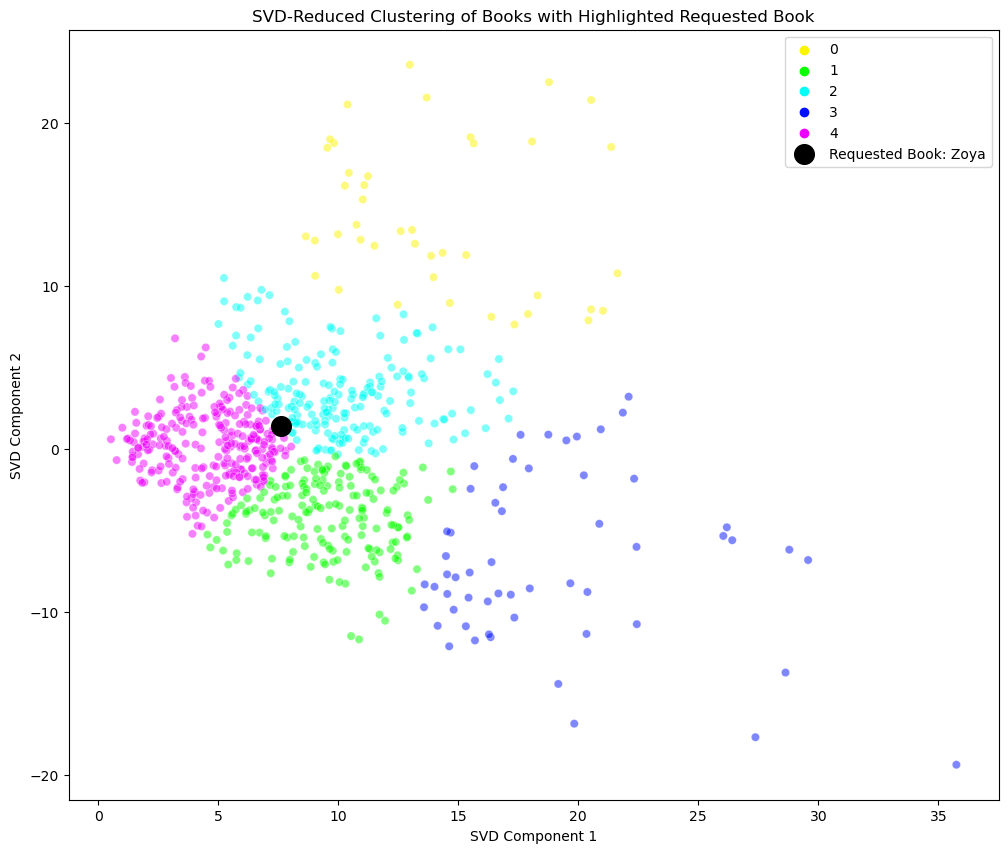

In [49]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming book_pivot is already defined and is a dense DataFrame now
# If book_pivot was a sparse matrix, convert it back to dense DataFrame for TruncatedSVD
# book_sparse = csr_matrix(book_pivot)

# Dimensionality Reduction with TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
book_svd = svd.fit_transform(book_pivot)  # Using the dense DataFrame directly

# Clustering with K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(book_svd)

# User Input for the book name
user_input_book_name = 'Zoya'  # Replace with the actual book title you want to visualize

# Check if the book exists in the pivot table
if user_input_book_name in book_pivot.index:
    book_idx = np.where(book_pivot.index == user_input_book_name)[0][0]  # Get the index of the book
    book_cluster = clusters[book_idx]  # Find the cluster of the requested book

    # Visualization
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=book_svd[:, 0], y=book_svd[:, 1], hue=clusters, palette=sns.color_palette("hsv", 5), alpha=0.5)
    plt.scatter(book_svd[book_idx, 0], book_svd[book_idx, 1], s=200, color='black', label='Requested Book: ' + user_input_book_name)
    plt.title('SVD-Reduced Clustering of Books with Highlighted Requested Book')
    plt.xlabel('SVD Component 1')
    plt.ylabel('SVD Component 2')
    plt.legend()
    plt.show()
else:
    print("The book title you entered is not found. Please check the spelling or try another title.")
